In [1]:
problem_statement="""
1. 
A system was hacked, but meta data of each session that the hackers used to connect to their servers were found. 
Dataset: hack_data.csv

Data Descriptions: 
'Session_Connection_Time': How long the session lasted in minutes
'Bytes Transferred': Number of MB transferred during session
'Kali_Trace_Used': Indicates if the hacker was using Kali Linux
'Servers_Corrupted': Number of server corrupted during the attack
'Pages_Corrupted': Number of pages illegally accessed
'Location': Location attack came from (Probably useless because the hackers used VPNs)
'WPM_Typing_Speed': Their estimated typing speed based on session logs.

There are 3 potential hackers, 2 confirmed hackers, 1 not yet confirmed. 

The data analyst knows that the hackers trade off attacks. Meaning they should each have roughly the same number of attacks. For example, if there were 100 total attacks, then in a 2-hacker situation each should have about 50 hacks, in a three-hacker situation each would have about 33 hacks.

Hint: the data analyst mentioned that the attacks should be evenly numbered between the hackers. Let's check with the transform and prediction columns for values of k. 

"""

notes="""
Pyspark.ml OneHotEncoder for Location
https://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=onehotencoder
"""

In [2]:
data_path = '/home/hadoop/Downloads/hack_data.csv'

In [3]:
try:
    sc.stop()
except:
    print('no sc to stop')

In [4]:
# some imports may repeat for modularity inside ipynb cells

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession 

from pyspark.sql.types import StructField, StringType, IntegerType, StructType
from pyspark.mllib.stat import Statistics 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
conf = SparkConf().setAppName('hw39_conf').setMaster('local[4]')
sc = SparkContext.getOrCreate(conf = conf)

spark = SparkSession.builder.appName('hw39_builder').getOrCreate()
sc

<SparkContext master=local[4] appName=hw39_conf>

In [7]:
df = spark.read.csv('file://{}'.format(data_path), header=True, inferSchema=True)

In [8]:
df.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)



In [9]:
df.take(5)

[Row(Session_Connection_Time=8.0, Bytes Transferred=391.09, Kali_Trace_Used=1, Servers_Corrupted=2.96, Pages_Corrupted=7.0, Location='Slovenia', WPM_Typing_Speed=72.37),
 Row(Session_Connection_Time=20.0, Bytes Transferred=720.99, Kali_Trace_Used=0, Servers_Corrupted=3.04, Pages_Corrupted=9.0, Location='British Virgin Islands', WPM_Typing_Speed=69.08),
 Row(Session_Connection_Time=31.0, Bytes Transferred=356.32, Kali_Trace_Used=1, Servers_Corrupted=3.71, Pages_Corrupted=8.0, Location='Tokelau', WPM_Typing_Speed=70.58),
 Row(Session_Connection_Time=2.0, Bytes Transferred=228.08, Kali_Trace_Used=1, Servers_Corrupted=2.48, Pages_Corrupted=8.0, Location='Bolivia', WPM_Typing_Speed=70.8),
 Row(Session_Connection_Time=20.0, Bytes Transferred=408.5, Kali_Trace_Used=0, Servers_Corrupted=3.57, Pages_Corrupted=8.0, Location='Iraq', WPM_Typing_Speed=71.28)]

In [10]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Session_Connection_Time,334,30.008982035928145,14.088200614636158,1.0,60.0
Bytes Transferred,334,607.2452694610777,286.33593163576757,10.0,1330.5
Kali_Trace_Used,334,0.5119760479041916,0.5006065264451406,0,1
Servers_Corrupted,334,5.258502994011977,2.30190693339697,1.0,10.0
Pages_Corrupted,334,10.838323353293413,3.06352633036022,6.0,15.0
Location,334,None,None,Afghanistan,Zimbabwe
WPM_Typing_Speed,334,57.342395209580864,13.41106336843464,40.0,75.0


In [11]:
from pyspark.sql.functions import count, when, isnan, \
                            isnull, mean, regexp_extract, col

In [12]:
def get_nulls(df):
    return(
        df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()
        )

get_nulls(df)


+-----------------------+-----------------+---------------+-----------------+---------------+--------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------+----------------+
|                      0|                0|              0|                0|              0|       0|               0|
+-----------------------+-----------------+---------------+-----------------+---------------+--------+----------------+



In [13]:
#### EDA

In [14]:
df.groupby('Location').count().show()

#df.groupby('Location').count().sort('count', asc=False).take(5)
# df.groupby('Location').count().sort('count', desc=False).show()

+--------------------+-----+
|            Location|count|
+--------------------+-----+
|            Anguilla|    1|
|            Paraguay|    2|
|               Macao|    2|
|Heard Island and ...|    2|
|               Yemen|    1|
|             Tokelau|    2|
|              Sweden|    3|
|French Southern T...|    3|
|            Kiribati|    1|
|              Guyana|    2|
|         Philippines|    3|
|            Malaysia|    2|
|           Singapore|    1|
|United States Vir...|    6|
|              Turkey|    1|
|      Western Sahara|    2|
|              Malawi|    2|
|                Iraq|    3|
|Northern Mariana ...|    3|
|             Germany|    1|
+--------------------+-----+
only showing top 20 rows



In [15]:
#https://spark.apache.org/docs/2.4.7/api/python/pyspark.ml.html#pyspark.ml.feature.OneHotEncoder
    


from pyspark.ml.feature import OneHotEncoder, StringIndexer

ohe_si = StringIndexer(inputCol="Location", outputCol="indexed_loc")
ohe_model = ohe_si.fit(df) 
df=ohe_model.transform(df)

#params = {encoder.dropLast: False, encoder.outputCol: "ohe"}

ohe = OneHotEncoder(inputCol='indexed_loc', outputCol='ohe_loc')
x =ohe.transform(df)

#ohe.fit(df)
df = ohe.transform(df)

In [16]:
df.select('Location','ohe_loc').show(truncate=False)

+------------------------+-----------------+
|Location                |ohe_loc          |
+------------------------+-----------------+
|Slovenia                |(180,[54],[1.0]) |
|British Virgin Islands  |(180,[37],[1.0]) |
|Tokelau                 |(180,[63],[1.0]) |
|Bolivia                 |(180,[161],[1.0])|
|Iraq                    |(180,[15],[1.0]) |
|Marshall Islands        |(180,[169],[1.0])|
|Georgia                 |(180,[52],[1.0]) |
|Timor-Leste             |(180,[40],[1.0]) |
|Palestinian Territory   |(180,[13],[1.0]) |
|Bangladesh              |(180,[94],[1.0]) |
|Northern Mariana Islands|(180,[21],[1.0]) |
|Zimbabwe                |(180,[29],[1.0]) |
|Isle of Man             |(180,[31],[1.0]) |
|Sao Tome and Principe   |(180,[78],[1.0]) |
|Greece                  |(180,[19],[1.0]) |
|Solomon Islands         |(180,[170],[1.0])|
|Guinea-Bissau           |(180,[2],[1.0])  |
|Burkina Faso            |(180,[36],[1.0]) |
|Mongolia                |(180,[61],[1.0]) |
|Nigeria  

In [17]:
def sns_countplot(df, col):
    plt.figure(figsize=(24,12))
    ax= sns.countplot(x=col, data=df.toPandas())
    plt.xlabel(str(col), fontsize = 13)
    plt.ylabel("count", fontsize = 13)
    plt.show()

    
def sns_dist(df, col, bins=None):
    plt.figure(figsize=(24,12))
    ax= sns.distplot(a= df.select(col).toPandas(),
                    bins=bins)
    plt.xlabel(col, fontsize = 13)
    plt.ylabel("count", fontsize = 13)
    plt.show()

In [18]:
display(df.columns)


['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location',
 'WPM_Typing_Speed',
 'indexed_loc',
 'ohe_loc']

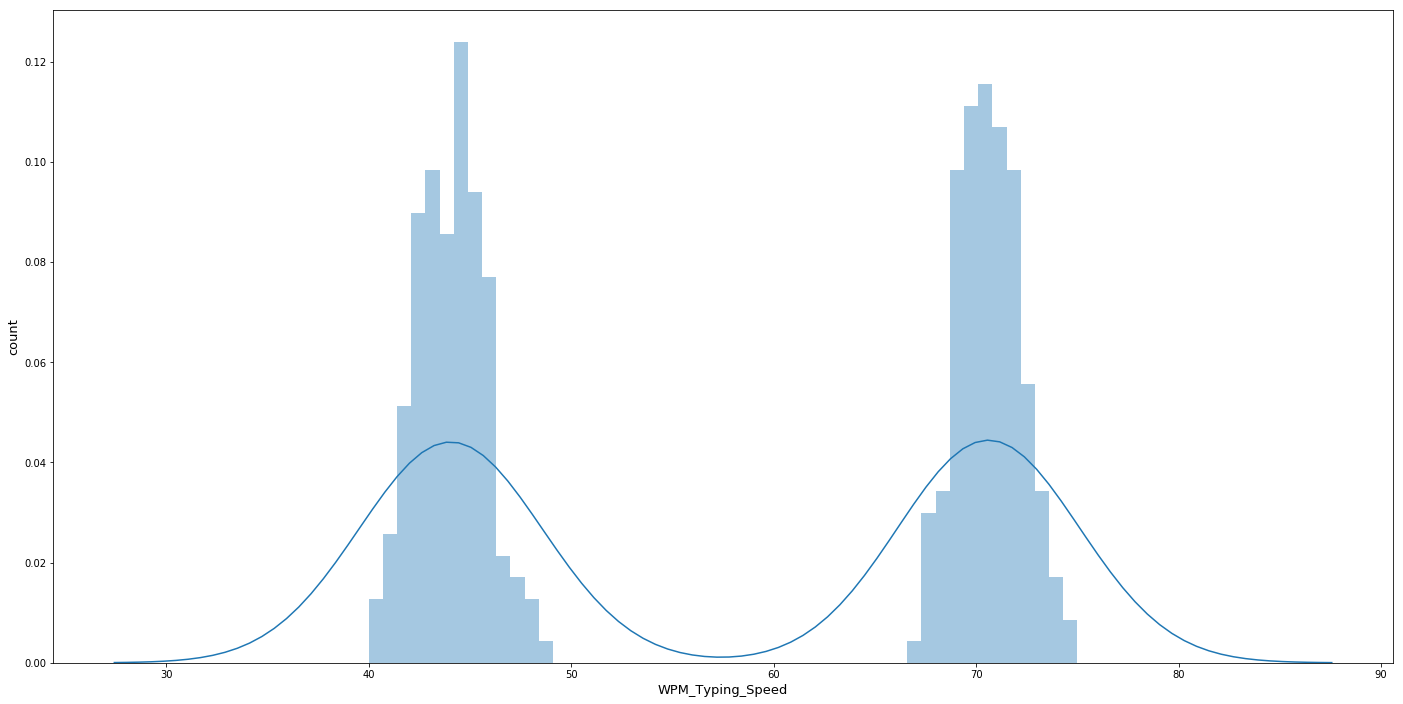

In [19]:
sns_dist(df, "WPM_Typing_Speed", bins=50)

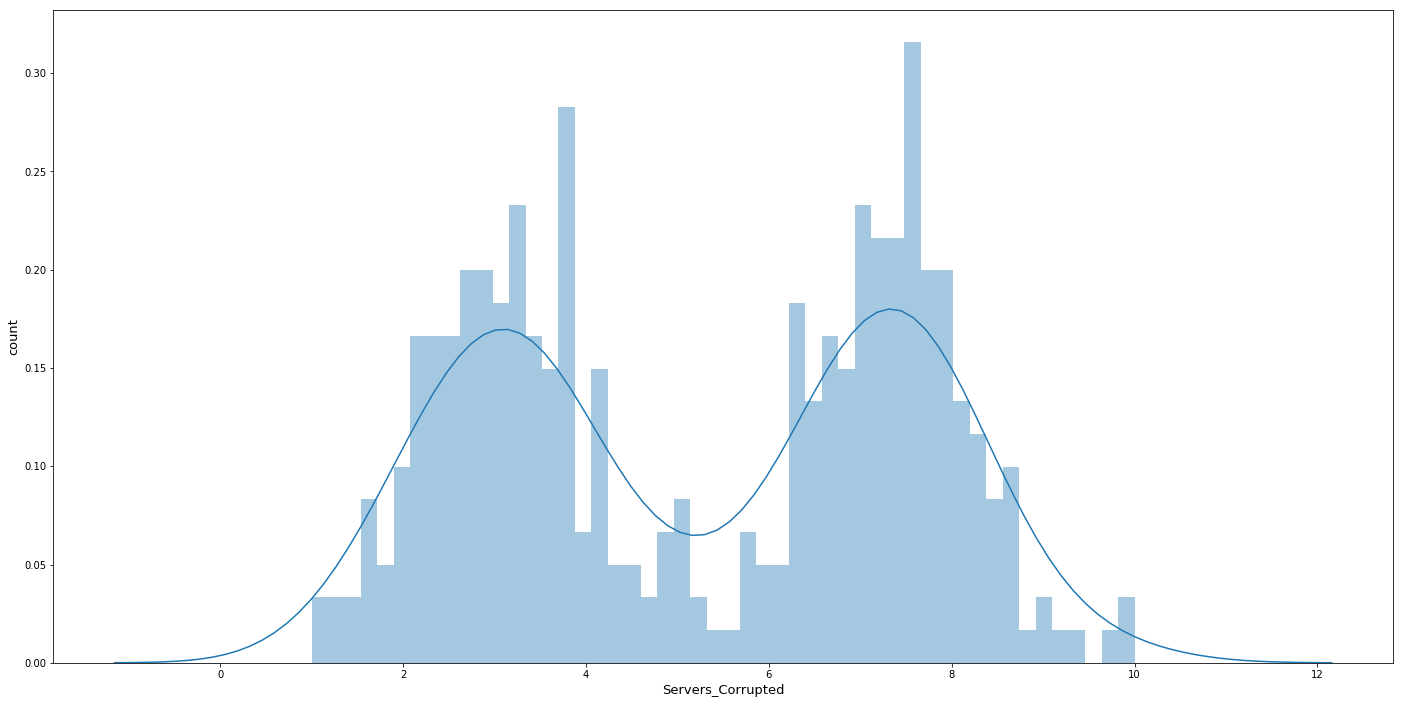

In [20]:
sns_dist(df, "Servers_Corrupted", bins=50)

In [21]:
display("""
Words per minute data seems to support hypothesis that there are two attackers.

Looks like two normal distributions (with different means/centers) of WPM metric.

One centered ~45wpm, other ~70wpm.

This does not preclude possibility that there is a third attacker.
""")

'\nWords per minute data seems to support hypothesis that there are two attackers.\n\nLooks like two normal distributions (with different means/centers) of WPM metric.\n\nOne centered ~45wpm, other ~70wpm.\n\nThis does not preclude possibility that there is a third attacker.\n'

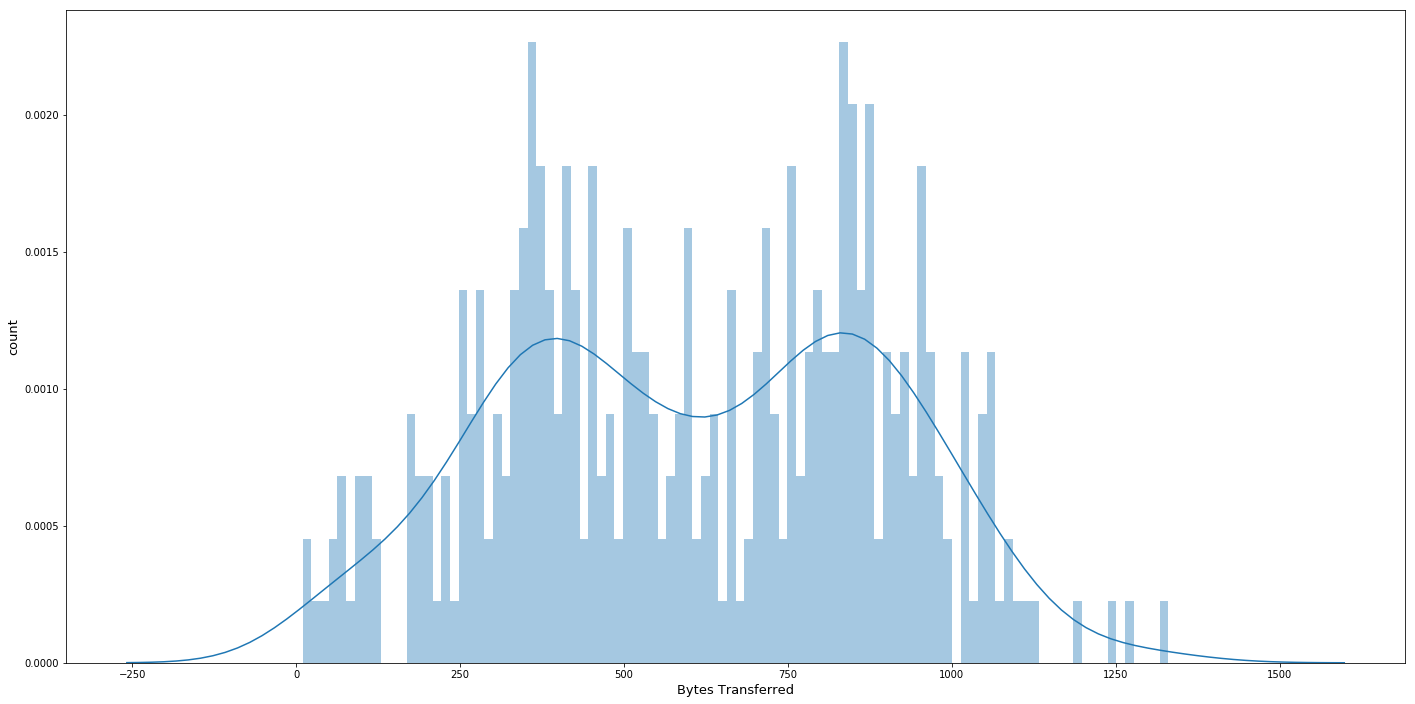

In [22]:
sns_dist(df, 'Bytes Transferred', bins=100)

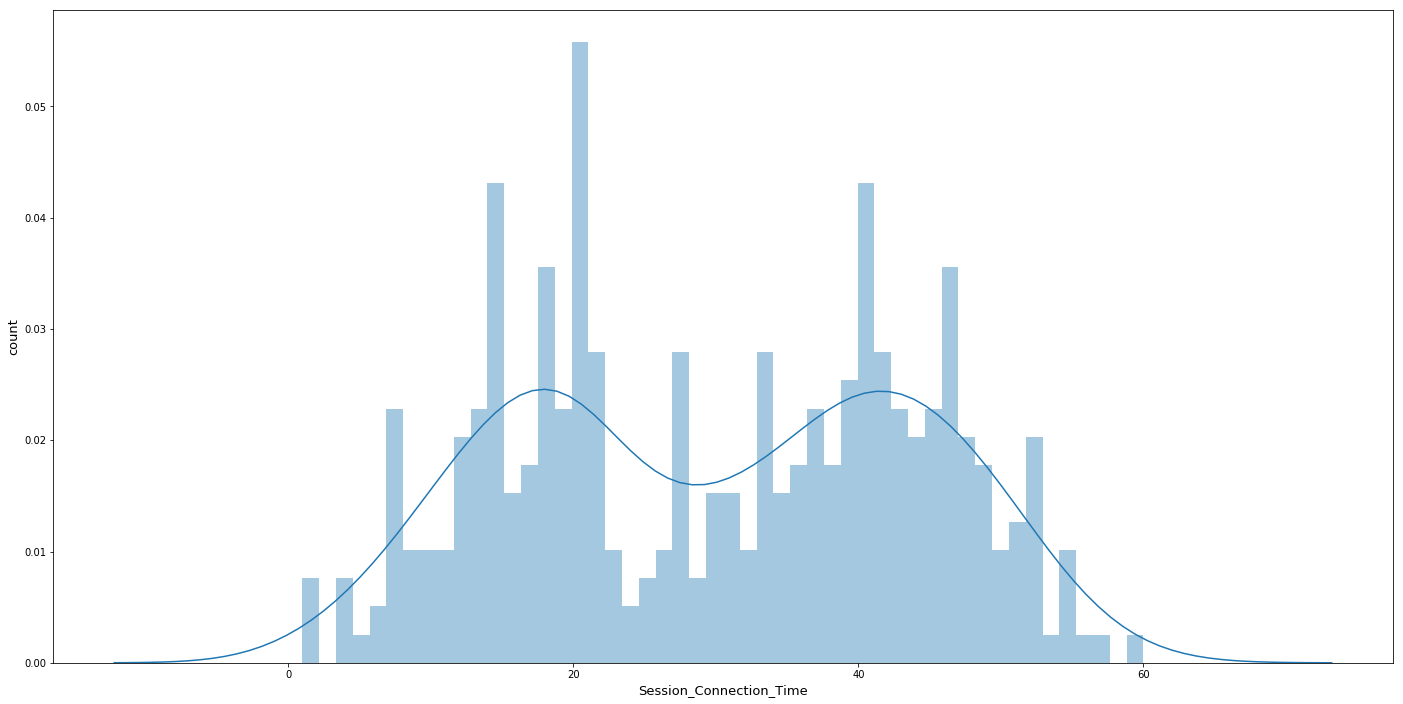

In [23]:
sns_dist(df, "Session_Connection_Time", bins=50)

In [24]:
features0_lst= [s for s in df.columns if s not in ["Location"]]
features0_lst

#features1_lst = ['ohe_loc']

['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'WPM_Typing_Speed',
 'indexed_loc',
 'ohe_loc']

In [25]:
from pyspark.ml.feature import VectorAssembler


In [26]:
assembler = VectorAssembler(inputCols= features0_lst,
                           outputCol='features')
#Input columns will convert into DenseVector
df = assembler.transform(df)

In [27]:
df.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)
 |-- indexed_loc: double (nullable = false)
 |-- ohe_loc: vector (nullable = true)
 |-- features: vector (nullable = true)



In [28]:
# as the range for the features is the same, we dn't need to apply feature pre-processing (scaling)

In [29]:
df.select('features').show(truncate=False)

+--------------------------------------------------------------------+
|features                                                            |
+--------------------------------------------------------------------+
|(187,[0,1,2,3,4,5,6,61],[8.0,391.09,1.0,2.96,7.0,72.37,54.0,1.0])   |
|(187,[0,1,3,4,5,6,44],[20.0,720.99,3.04,9.0,69.08,37.0,1.0])        |
|(187,[0,1,2,3,4,5,6,70],[31.0,356.32,1.0,3.71,8.0,70.58,63.0,1.0])  |
|(187,[0,1,2,3,4,5,6,168],[2.0,228.08,1.0,2.48,8.0,70.8,161.0,1.0])  |
|(187,[0,1,3,4,5,6,22],[20.0,408.5,3.57,8.0,71.28,15.0,1.0])         |
|(187,[0,1,2,3,4,5,6,176],[1.0,390.69,1.0,2.79,9.0,71.57,169.0,1.0]) |
|(187,[0,1,2,3,4,5,6,59],[18.0,342.97,1.0,5.1,7.0,72.32,52.0,1.0])   |
|(187,[0,1,2,3,4,5,6,47],[22.0,101.61,1.0,3.03,7.0,72.03,40.0,1.0])  |
|(187,[0,1,2,3,4,5,6,20],[15.0,275.53,1.0,3.53,8.0,70.17,13.0,1.0])  |
|(187,[0,1,2,3,4,5,6,101],[12.0,424.83,1.0,2.53,8.0,69.99,94.0,1.0]) |
|(187,[0,1,2,3,4,5,6,28],[15.0,249.09,1.0,3.39,9.0,70.77,21.0,1.0])  |
|(187,

In [30]:
#train, test = df.randomSplit([.85,.15], seed=13)
train, test = df.randomSplit([.8,.2], seed=1313)

In [31]:
# Elbow method

In [32]:
from pyspark.ml.clustering import KMeans

In [33]:
# Within-Cluster-Sum-of-Squares

## Here we are operating on whole dataset

max_k = 10

wcss = np.zeros(max_k)

for k in range(2, max_k):
    kmeans = KMeans().setK(k)\
            .setSeed(131)\
            .setFeaturesCol('features')\
            .setPredictionCol('cluster')\
            .setMaxIter(100)
    #model = kmeans.fit(train)
    model = kmeans.fit(df)
    #wcss[k] = model.computeCost(train)
    wcss[k] = model.computeCost(df)

In [34]:


display([i for i in zip(range(2,max_k), wcss, )])

display([(i, round(wcss[i],2), round(wcss[i-1]-wcss[i],2)) for i in range(2,max_k)])

[(2, 0.0),
 (3, 0.0),
 (4, 7781272.335882546),
 (5, 4872462.0997239575),
 (6, 3345359.5454956302),
 (7, 2407686.9006513627),
 (8, 2090123.1506003672),
 (9, 1714011.616414203)]

[(2, 7781272.34, -7781272.34),
 (3, 4872462.1, 2908810.24),
 (4, 3345359.55, 1527102.55),
 (5, 2407686.9, 937672.64),
 (6, 2090123.15, 317563.75),
 (7, 1714011.62, 376111.53),
 (8, 1561830.7, 152180.91),
 (9, 1360714.71, 201115.99)]

In [35]:
""" # note prepped without oneHot location

ix     wcss         wcss_change

[(2,   6915193.17, -6915193.17),
 (3,   4081151.04,  2834042.13),
 (4,   2462725.87,  1618425.18), # Visually, 4 or 5 is the elbow
 (5,   1546845.98,   915879.89), # But by proportion of change, maybe k=5 is worth considering?
 (6,   1152328.34,   394517.64), 
 (7,    925804.4,    226523.94),
 (8,    673907.47,   251896.93),
 (9,    575155.96,    98751.51)]


Regardless, problem statement says there are either 2 or 3, not 5 attackers.
"""

' # note prepped without oneHot location\n\nix     wcss         wcss_change\n\n[(2,   6915193.17, -6915193.17),\n (3,   4081151.04,  2834042.13),\n (4,   2462725.87,  1618425.18), # Visually, 4 or 5 is the elbow\n (5,   1546845.98,   915879.89), # But by proportion of change, maybe k=5 is worth considering?\n (6,   1152328.34,   394517.64), \n (7,    925804.4,    226523.94),\n (8,    673907.47,   251896.93),\n (9,    575155.96,    98751.51)]\n\n\nRegardless, problem statement says there are either 2 or 3, not 5 attackers.\n'

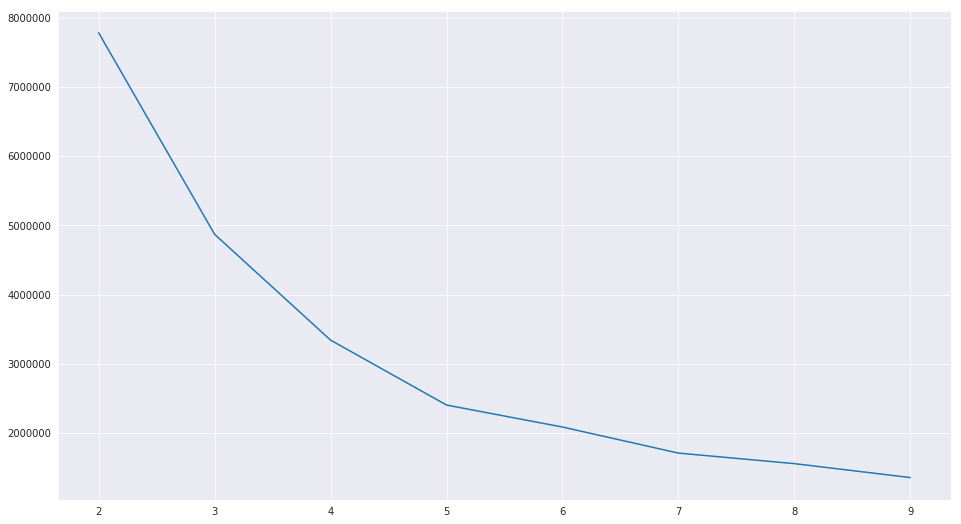

In [36]:
sns.set_style('darkgrid')
ax=plt.figure(figsize=(16,9))
plt.plot(range(2,max_k), wcss[2:max_k])

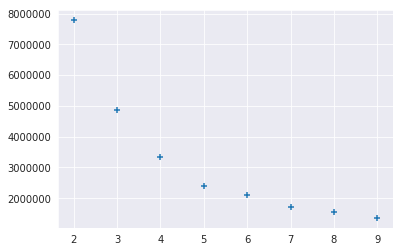

In [37]:
plt.scatter(range(2,max_k), wcss[2:max_k], marker='+')
plt.xlabel=('k')
plt.ylabel=('WCSS')
plt.show()

In [38]:
# From elbow method optimum number of k == 4?

In [39]:
####
## Here we are operating on only training dataset


kmeans = KMeans().setK(5)\
        .setSeed(1)\
        .setFeaturesCol('features')\
        .setPredictionCol('cluster')\
        .setMaxIter(100)

model = kmeans.fit(train)

wcss = model.computeCost(train)

print(wcss)

2001518.4403910665


In [40]:
# def get_kmeans_wcss_model(df, k):
#     kmeans = KMeans().setK(4)\
#         .setSeed(1)\
#         .setFeaturesCol('features')\
#         .setPredictionCol('cluster')\
#         .setMaxIter(100)

#     model = kmeans.fit(train)

#     wcss = model.computeCost(train)

#     return(wcss, model)


In [41]:
print(model.computeCost(test))

414811.6208209779


In [42]:
# provides predicted clusters for test samples
predict_cluster = model.transform(test)
predict_cluster_train = model.transform(train)

In [43]:
predict_cluster.groupby('cluster').count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1|    5|
|      3|   18|
|      4|   15|
|      2|   11|
|      0|    8|
+-------+-----+



In [44]:
predict_cluster_train.groupby('cluster').count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1|   27|
|      3|   74|
|      4|   78|
|      2|   51|
|      0|   47|
+-------+-----+

